In [1]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np

from histomicstk.preprocessing.color_normalization import deconvolution_based_normalization

In [2]:
image_paths = sorted(["data/images/"+path for path in os.listdir("data/images") if not path.startswith(".")])

In [3]:
images = list(map(tifffile.imread, image_paths))

uint8


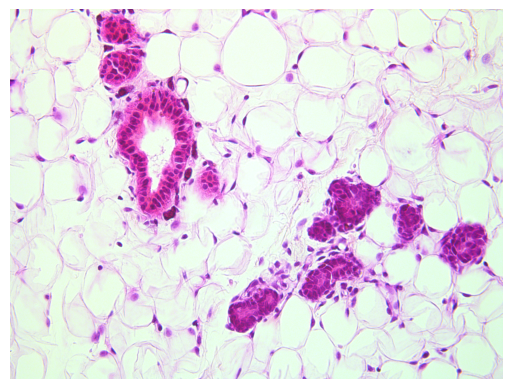

In [4]:
reference_image = tifffile.imread("data/reference/E2+P4+DHT_4_M14_3L_0004.tif")
print(reference_image.dtype)
plt.axis(False)
plt.imshow(reference_image)

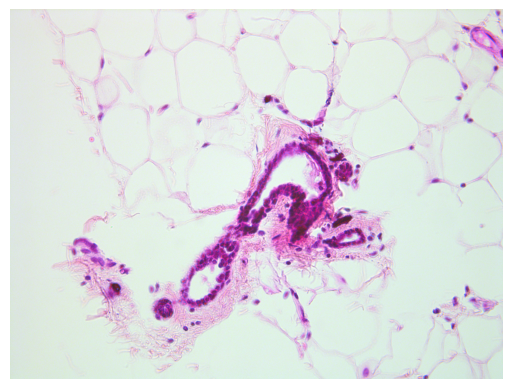

In [5]:
test_image = images[0]
plt.axis(False)
plt.imshow(test_image)

In [6]:
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)

In [7]:
mask_out, _ = get_tissue_mask(
    test_image, deconvolve_first=True,
    n_thresholding_steps=1, sigma=1.5, min_size=30)

In [8]:
from skimage.transform import resize

mask_out_fixed = resize(
    mask_out == 0, output_shape=test_image.shape[:2],
    order=0, preserve_range=True) == 1

In [16]:
def create_mask(img):
    mask_out, _ = get_tissue_mask(
    img, deconvolve_first=True,
    n_thresholding_steps=1, sigma=1.5, min_size=30)

    mask_out_fixed = resize(
    mask_out == 0, output_shape=test_image.shape[:2],
    order=0, preserve_range=True) == 1

    return mask_out_fixed

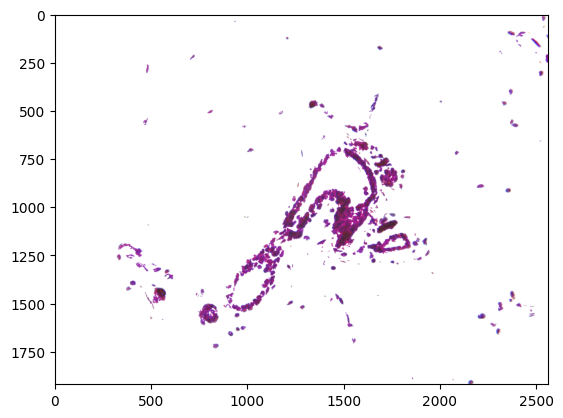

In [10]:
masked_out_test_image = test_image.copy()
masked_out_test_image[mask_out_fixed] = [255, 255, 255]
plt.imshow(masked_out_test_image)

In [11]:
from utils.helpers import compare_two_images

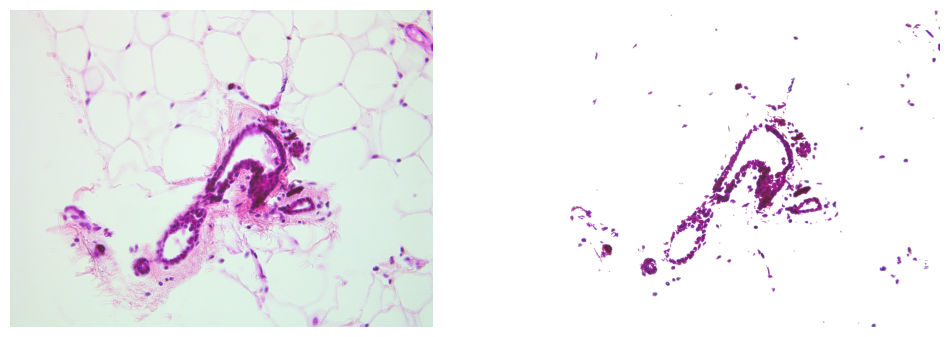

In [12]:
compare_two_images(test_image, masked_out_test_image)

In [13]:
def color_normalization_macenko(target_img, reference_img, mask=None, stains=['hematoxylin', 'eosin'], stain_unmixing_method='macenko_pca'):
    stain_unmixing_routine_params = {
        'stains': stains,
        'stain_unmixing_method': stain_unmixing_method
    }

    normalized_target_img = deconvolution_based_normalization(
            target_img, im_target=reference_img,
            mask_out = mask,
            stain_unmixing_routine_params=stain_unmixing_routine_params,)

    return normalized_target_img

In [17]:
masks = [create_mask(img) for img in images]

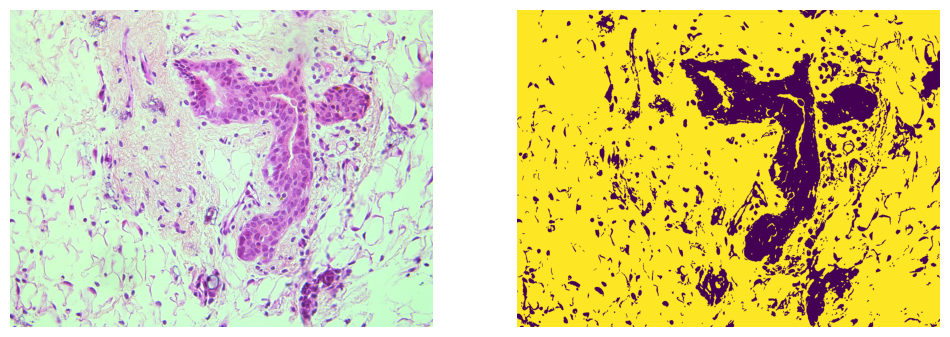

In [18]:
compare_two_images(images[5], masks[5])

In [19]:
normalized_images = [color_normalization_macenko(image, reference_image, masks[i]) for i, image in enumerate(images)]

In [56]:
# for img, norm_img in zip(images, normalized_images):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.axis(False)
#     plt.title("Original image")
#     plt.imshow(img)

#     plt.subplot(1, 2, 2)
#     plt.axis(False)
#     plt.title("Normalized image")
#     plt.imshow(norm_img)

#     plt.show()

In [27]:
from histomicstk.preprocessing.color_normalization import reinhard

In [28]:
def normalize_reinhard(target_image, mask=None):
    cnorm = {
        'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
        'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
    }

    normalized_image = target_image.copy()

    normalized_image = reinhard(
        normalized_image, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'],
        mask_out=mask)

    return normalized_image


In [31]:
import histomicstk as htk

In [34]:
def extract_hema_sup(img, sparsity_factor=0.5, I_0=255):
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    stains = ['hematoxylin',
            'eosin',
            'null']

    W = np.array([stain_color_map[st] for st in stains]).T
    W_init = W[:, :2]

    im_sda = htk.preprocessing.color_conversion.rgb_to_sda(img, I_0)
    W_est = htk.preprocessing.color_deconvolution.separate_stains_xu_snmf(
        im_sda, W_init, sparsity_factor,
    )
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(img, W)

    return imDeconvolved

In [37]:
hema_test = extract_hema_sup(test_image)

In [47]:
hema_test_unsup = extract_hema_unsup(test_image)

In [50]:
test_image.shape

(1920, 2560, 3)

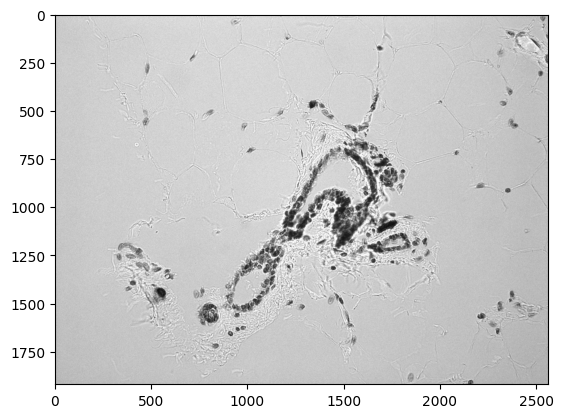

In [45]:
plt.imshow(hema_test.Stains[:, :, 0], cmap="grey")

In [42]:
hema_test.Stains[:, :, 0]

array([[171, 179, 188, ..., 183, 192, 202],
       [172, 179, 185, ..., 184, 190, 197],
       [173, 178, 182, ..., 185, 188, 192],
       ...,
       [181, 178, 176, ..., 162, 168, 175],
       [171, 170, 168, ..., 161, 166, 171],
       [161, 161, 160, ..., 160, 163, 167]], dtype=uint8)

In [51]:
def rgb_to_od(img):
    img = img.astype(np.float32)
    img[img == 0] = 1  # Avoid division by zero
    return -np.log(img / 255)

In [52]:
import cv2
import numpy as np
from sklearn.decomposition import PCA